<a href="https://colab.research.google.com/github/PLEX-GR00T/Cart_Pole_LQR/blob/main/Kalman_Gain_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
from matplotlib import pyplot as plt
from numpy.linalg import inv
import numpy as np
import pandas as pd
import random

In [50]:
M = 1
m = 0.3
b = 0.1
l = 1
I = 0.001
g = 9.8

A = (I + (m*(l**2)))
B = (I*(M+m) + (M*m*(l)**2))
C = ((m**2)*g*(l**2))
D = (-m*l*b)
E = ((m*g*l)*(M+m))
f = (m*l)

AA = -A*b/B
BB = C/B
CC = D/B
DD = E/B

EE = A/B
FF = f/B

N = 500

dt = 0.01

In [51]:
Tb = np.array([
            [0, 1,  0,  0],
            [0, AA, BB, 0],
            [0, 0,  0,  1],
            [0, CC, DD, 0]]) 

Ta = np.array([[0], 
              [EE], 
              [0], 
              [FF]]) *dt

Identity = np.identity(4, dtype = float)
Ts = Identity + (Tb) * dt

Ra = -2
rho = 1
sigma_noise_val = 0.01
Rs = -np.array([[rho/20, 0, 0, 0],
                [0, rho/20, 0, 0],
                [0, 0, rho, 0],
                [0, 0, 0, rho/10]])

In [52]:
sigma_noise_matrix = np.identity(4) * sigma_noise_val

v = dict()
q = dict()

v[N] = Rs
q[N] = 0

L = dict() # 1 to 1001

In [53]:
for i in range(N, 1, -1):
  v[i-1] = Rs + (Ts.T @ v[i].T @ Ts) - ((Ta.T @ v[i] @ Ts).T) * (inv(Ra + Ta.T @ v[i] @ Ta)) @ (Ta.T @ v[i] @ Ts)
  q[i-1] = q[i] + np.trace(sigma_noise_matrix @ v[i])

for i in range(1, N+1, 1):
    L[i] = ((Ra + Ta.T @ v[i] @ Ta)**(-1)) @ (Ta.T @ v[i] @ Ts)

In [71]:
print((5)**(-1))

0.2


In [67]:
print(L[N].shape)

(1, 4)


In [54]:
print(v[N-1])
print(q[N-1])
print(L[N])

[[-1.00000000e-01 -5.00000000e-04  0.00000000e+00  0.00000000e+00]
 [-5.00000000e-04 -9.99051246e-02 -1.44952989e-03  9.98164660e-05]
 [ 0.00000000e+00 -1.44952989e-03 -2.00165194e+00 -2.26849614e-02]
 [ 0.00000000e+00  9.98164660e-05 -2.26849614e-02 -2.00099504e-01]]
-0.012
[[0.00000000e+00 2.49004026e-04 7.04619768e-05 4.97838972e-04]]


In [55]:
sd_v = 0.0321
V_ = np.identity(2) * sd_v
sd_w = 0.0123
W_ = np.identity(4) * sd_w

# sensor matrix : 
C_ = np.array([
            [0, 1, 0, 0],            
            [0, 0, 0, 1]])
Sigma = dict()
Sigma[0] = np.identity(4) * 0.01

X = dict()
X[0] = np.array([[0.1], 
                [-0.05], 
                [0.1], 
                [0.01]])
F = dict()
F[0] = 0

S = dict()
S[0] = np.array([[0.1], 
                [-0.05], 
                [0.1], 
                [0.01]])
K = dict()

Wk = np.random.multivariate_normal([0,0,0,0], W_).reshape(4,1)
Vk = np.random.multivariate_normal([0,0], V_).reshape(2,1)

In [56]:
print(Wk)
print(Vk)

[[ 0.07171116]
 [-0.05556146]
 [-0.01108148]
 [ 0.14937189]]
[[-0.25027369]
 [-0.4393299 ]]


In [57]:
def S_calc(n):
    S[n] = (Ts @ S[n-1]) + (Ta * F[n]) #+ Wk
    return S[n]

def Y_(n):
    if n==0:
        Y = (C_ @ S[0]) #+ Vk
        return Y
    else:
        Y = (C_ @ S_calc(n)) #+ Vk
        return Y

In [58]:
for i in range(1,N,1):
    Sigma[i] = W_ + (Ts @ Sigma[i-1] @ Ts.T) - (Ts @ Sigma[i-1] @ C_.T) @ (inv(V_ + C_ @ Sigma[i-1] @ C_.T)) @ (C_ @ Sigma[i-1] @ Ts.T)
  
for i in range(1,N+1,1):
    K[i] = (Ts @ Sigma[i-1] @ C_.T) @ (inv(V_ + C_ @ Sigma[i-1] @ C_.T))
    X[i] = (Ts @ X[i-1]) + (K[i] @ (Y_(i-1) - C_ @ X[i-1]))
    F[i] = -(L[i] @ X[i])

In [75]:
print(K[1].shape)

(4, 2)


In [66]:
print(L[N])
print(X[N])

[[0.00000000e+00 2.49004026e-04 7.04619768e-05 4.97838972e-04]]
[[-55.00010433]
 [ 57.50427513]
 [139.15057962]
 [493.66121329]]


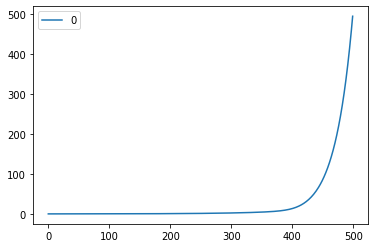

In [73]:
pd.DataFrame([X[i][3][0]for i in range(1,len(X))]).plot()

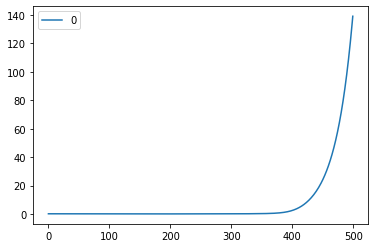

In [70]:
pd.DataFrame([X[i][2][0]for i in range(1,len(X))]).plot()

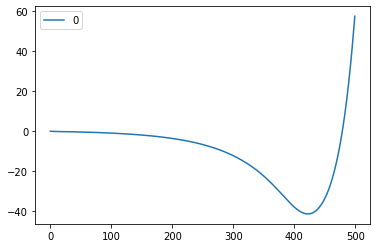

In [69]:
pd.DataFrame([X[i][1][0]for i in range(1,len(X))]).plot()

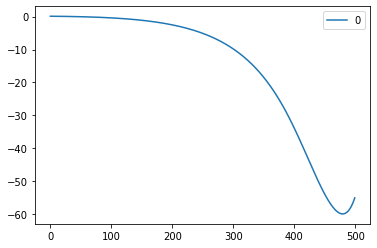

In [65]:
pd.DataFrame([X[i][0][0]for i in range(1,len(X))]).plot()

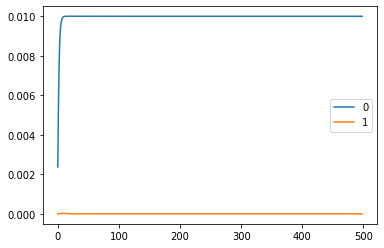

In [60]:
pd.DataFrame([K[i][0]for i in range(1,len(K))]).plot()

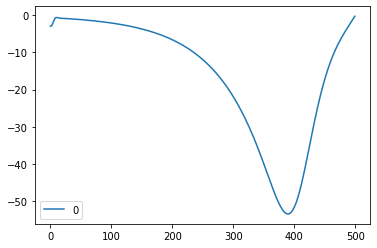

In [61]:
pd.DataFrame([F[i][0]for i in range(1,len(F))]).plot()

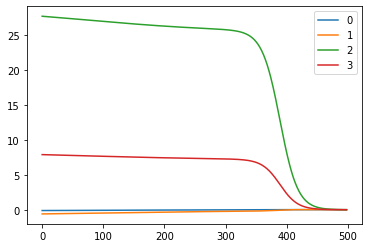

In [62]:
pd.DataFrame([L[i][0]for i in range(1,len(L))]).plot()

In [63]:
print(F[N])
print(X[N])

[[-0.26988741]]
[[-55.00010433]
 [ 57.50427513]
 [139.15057962]
 [493.66121329]]


Text(0.5, 1.0, 'Angular_Velocity v/s Time')

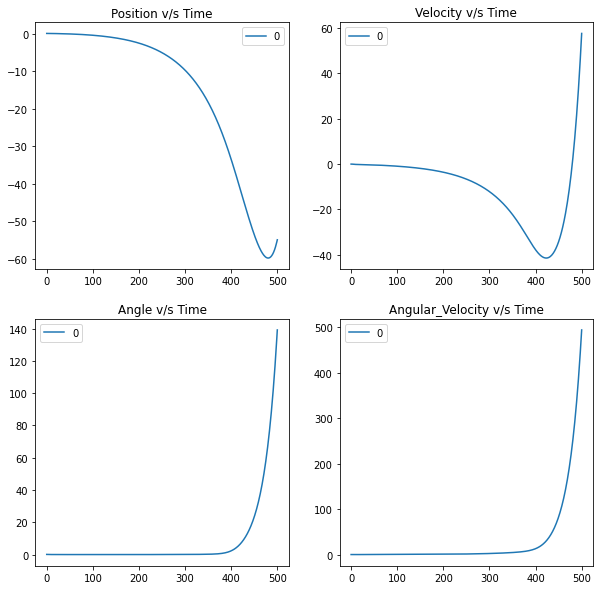

In [72]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
pd.DataFrame([float(X[i][0][0]) for i in X]).plot(ax=axes[0,0]); axes[0,0].set_title('Position v/s Time')
pd.DataFrame([float(X[i][1][0]) for i in X]).plot(ax=axes[0,1]); axes[0,1].set_title('Velocity v/s Time')
pd.DataFrame([float(X[i][2][0]) for i in X]).plot(ax=axes[1,0]); axes[1,0].set_title('Angle v/s Time')
pd.DataFrame([float(X[i][3][0]) for i in X]).plot(ax=axes[1,1]); axes[1,1].set_title('Angular_Velocity v/s Time')